In [4]:
import os
import matplotlib.pyplot as plt
from pathlib import Path
import scanpy as sc
import pandas as pd

import time
import tracemalloc
import sys
sys.path.append('/home/lytq/Spatial-Transcriptomics-Benchmark/DeepST/DeepST-main/deepst')
from DeepST import run

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/home/lytq/Spatial-Transcriptomics-Benchmark/utils')
from evaluate import evaluate_clustering


In [5]:
data_path = "/home/lytq/Spatial-Transcriptomics-Benchmark/data/BRCA1" 
data_name = 'V1_Human_Breast_Cancer_Block_A_Section_1'


save_root = Path(f'/home/lytq/Spatial-Transcriptomics-Benchmark/Results/results3/BRCA1/DeepST/')
os.makedirs(save_root, exist_ok=True)


n_domains = 20
# n_domains = sys.argv[2]


In [10]:
start_time = time.time()
tracemalloc.start()

print('Processing', data_name, '...')

deepen = run(
    save_path = save_root,
    task = "Identify_Domain", #### DeepST includes two tasks, one is "Identify_Domain" and the other is "Integration"
    pre_epochs = 800, ####  choose the number of training
    epochs = 1000, #### choose the number of training
    use_gpu = True)

adata = deepen._get_adata(platform="Visium", data_path=data_path, data_name=data_name)

gt_df = pd.read_csv(data_path + '/' + data_name + '/metadata.tsv', sep='\t', index_col=0)
adata.obs['layer_guess'] = gt_df.loc[adata.obs_names, 'fine_annot_type']

adata.layers['count'] = adata.X.toarray()

###### Segment the Morphological Image
# adata = deepen._get_image_crop(adata, data_name=data_name)

###### Data augmentation. spatial_type includes three kinds of "KDTree", "BallTree" and "LinearRegress", among which "LinearRegress"
###### is only applicable to 10x visium and the remaining omics selects the other two.
###### "use_morphological" defines whether to use morphological images.
adata = deepen._get_augment(adata, spatial_type="KDTree", use_morphological=False)

###### Build graphs. "distType" includes "KDTree", "BallTree", "kneighbors_graph", "Radius", etc., see adj.py
graph_dict = deepen._get_graph(adata.obsm["spatial"], distType = "BallTree")

###### Enhanced data preprocessing
data = deepen._data_process(adata, pca_n_comps = 200)

###### Training models
deepst_embed = deepen._fit(
    data = data,
    graph_dict = graph_dict,
)
# Remove Image_crop folder after training
# os.system(f'rm -r {save_root}/Image_crop')

###### DeepST outputs
adata.obsm["DeepST_embed"] = deepst_embed

###### Define the number of space domains, and the model can also be customized. If it is a model custom priori = False.
adata = deepen._get_cluster_data(adata, n_domains=n_domains, priori = True)
# print(adata)


###### Calculate the time and memory used
time_taken = time.time() - start_time
size, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
memory_used = peak / (1024 ** 2) # MB

####### Calculate clustering metrics
# obs_df = adata.obs.dropna()
clustering_results = evaluate_clustering(adata, gt_df, time_taken, memory_used, save_root,
                                         pred_key='DeepST_refine_domain', gt_df_key='fine_annot_type')
print(f'ARI = {clustering_results["ARI"]:.4f}')


Processing V1_Human_Breast_Cancer_Block_A_Section_1 ...
Physical distance calculting Done!
The number of nearest tie neighbors in physical distance is: 30.0
Gene correlation calculting Done!
The weight result of image feature is added to adata.obsm['weights_matrix_all'] !


Find adjacent spots of each spot: 100%|██████████ [ time left: 00:00 ]


Step 1: Augment molecule expression is Done!
12.0000 neighbors per cell on average.
Step 2: Graph computing is Done!
Your task is in full swing, please wait


DeepST trains an initial model: 100%|██████████ [ time left: 00:00 ]
DeepST trains a final model: |           [ time left: 00:00 ]    


Step 3: DeepST training has been Done!
Current memory usage：8.7864 GB
Total time: 1.53 minutes
Your task has been completed, thank you
Of course, you can also perform downstream analysis on the processed data
Best resolution:  0.8099999999999996
ARI = 0.5273


In [12]:
adata

AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow', 'layer_guess', 'leiden', 'DeepST_domain', 'DeepST_refine_domain', 'ground_truth', 'DeepST'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'neighbors', 'leiden', 'DeepST_refine_domain_colors'
    obsm: 'spatial', 'weights_matrix_all', 'adjacent_data', 'augment_gene_data', 'DeepST_embed'
    layers: 'count'
    obsp: 'distances', 'connectivities'

In [13]:
adata.obs['DeepST_shift'] = (adata.obs['DeepST_refine_domain'].astype(int) + 1).astype(str)

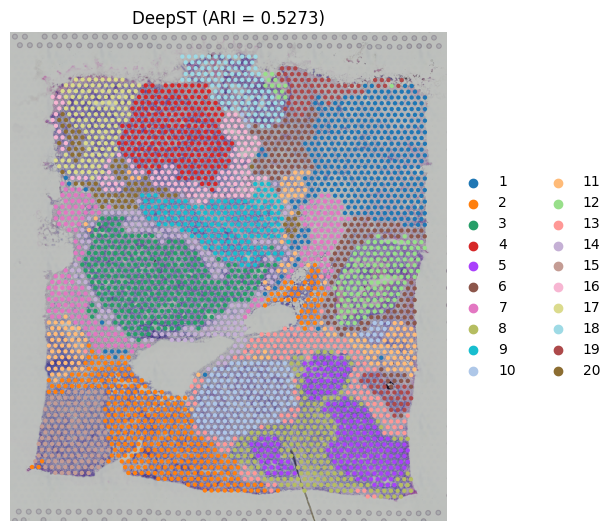

In [21]:
###### Spatial localization map of the spatial domain
fig, ax = plt.subplots(1, 1, figsize=(6, 6))        
sc.pl.spatial(adata, color='DeepST_shift', ax=ax, show=False)  
ax.set_title(f'DeepST (ARI = {clustering_results["ARI"]:.4f})')
ax.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(save_root, f'clustering.pdf'), bbox_inches='tight', dpi=300)
plt.show()

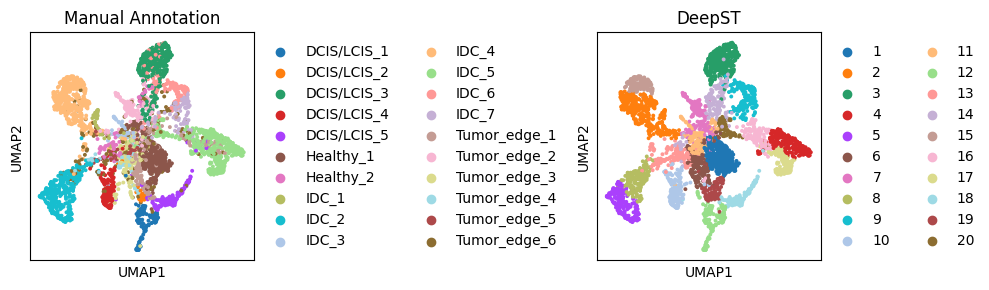

In [19]:
###### UMAP visualization
sc.pp.neighbors(adata, use_rep='DeepST_embed', n_neighbors=10)
sc.tl.umap(adata)

fig, axes = plt.subplots(1,2,figsize=(10, 3))
sc.pl.umap(adata, color='layer_guess', ax=axes[0], show=False)
sc.pl.umap(adata, color='DeepST_shift', ax=axes[1], show=False)
axes[0].set_title('Manual Annotation')
axes[1].set_title('DeepST')
plt.tight_layout()
plt.savefig(os.path.join(save_root, f'umap.pdf'), bbox_inches='tight', dpi=300)

In [22]:
adata

AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow', 'layer_guess', 'leiden', 'DeepST_domain', 'DeepST_refine_domain', 'ground_truth', 'DeepST', 'DeepST_shift'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'neighbors', 'leiden', 'DeepST_refine_domain_colors', 'DeepST_shift_colors', 'umap', 'layer_guess_colors'
    obsm: 'spatial', 'weights_matrix_all', 'adjacent_data', 'augment_gene_data', 'DeepST_embed', 'X_umap'
    layers: 'count'
    obsp: 'distances', 'connectivities'

In [23]:
low_dim_data = pd.DataFrame(adata.obsm['DeepST_embed'], index=adata.obs.index)
# expression_data = pd.DataFrame(adata.layers['count'], index=adata.obs.index, columns=adata.var.index)
cell_metadata = adata.obs

low_dim_data.to_csv(f"{save_root}/low_dim_data.csv")
# expression_data.T.to_csv(f"{save_root}/expression_matrix.csv")
cell_metadata.to_csv(f"{save_root}/cell_metadata.csv")

umap_coords = adata.obsm["X_umap"]
spot_ids = adata.obs_names
umap_df = pd.DataFrame(umap_coords, columns=["UMAP1", "UMAP2"])
umap_df["spot_id"] = spot_ids
umap_df = umap_df[["spot_id", "UMAP1", "UMAP2"]]
umap_df.to_csv(os.path.join(save_root, "spatial_umap_coords.csv"), index=False)

